In [25]:
import pandas as pd
import numpy as np

import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

from fetch_data import *

In [3]:
# Get data from the API
prices_data = fetchPriceData(id='bitcoin', vs_currency='usd')
ohlc_data = fetchCandleData(id='bitcoin', vs_currency='usd')

In [5]:
prices_data['EMA_9'] = prices_data['prices'].ewm(9).mean().shift()
prices_data['SMA_5'] = prices_data['prices'].rolling(5).mean().shift()
prices_data['SMA_10'] = prices_data['prices'].rolling(10).mean().shift()
prices_data['SMA_15'] = prices_data['prices'].rolling(15).mean().shift()
prices_data['SMA_30'] = prices_data['prices'].rolling(30).mean().shift()

In [10]:
def calculateRSI(prices_data, n=14):
    """Calculate the Relative Strength Index of an asset.

    Args:
        prices_data (pandas dataframe object): prices data
        n (int, optional): number of . Defaults to 14.
    Return:
        rsi (pandas series object): relative strength index
    """
    price = prices_data['prices']
    delta = price.diff()
    delta = delta[1:]

    prices_up = delta.copy()
    prices_up[prices_up < 0] = 0
    prices_down = delta.copy()
    prices_down[prices_down > 0] = 0

    roll_up = prices_up.rolling(n).mean()
    roll_down = prices_down.abs().rolling(n).mean()

    relative_strength = roll_up / roll_down
    rsi = 100.0 - (100.0 / (1.0 + relative_strength))

    return rsi

In [11]:
prices_data['RSI'] = calculateRSI(prices_data).fillna(0)

In [13]:
def calculateMACD(prices_data):
    """Calculate the MACD of EMA12 and EMA26 of an asset

    Args:
        prices_data (dataframe): prices data

    Returns:
        macd (pandas series object): macd of the asset
        macd_signal (pandas series object): macd signal of the asset
    """
    ema12 = pd.Series(prices_data['prices'].ewm(span=12, min_periods=12).mean())
    ema26 = pd.Series(prices_data['prices'].ewm(span=26, min_periods=26).mean())

    macd = pd.Series(ema12 - ema26)
    macd_signal = pd.Series(macd.ewm(span=9, min_periods=9).mean())

    return macd, macd_signal

In [17]:
macd, macd_signal = calculateMACD(prices_data)
prices_data['MACD'] = macd
prices_data['MACD_signal'] = macd_signal

In [18]:
# Shift label(y) col by one value to predict the next day using today's data (technical indicators)
prices_data['prices'] = prices_data['prices'].shift(-1)

In [20]:
# Drop invalid samples - the samples where moving averages exceed 
prices_data = prices_data.iloc[33:]
prices_data = prices_data[:-1] # since we did shifting by one
prices_data.index = range(len(prices_data)) # update indexes

In [21]:
prices_data.shape

(1766, 13)

In [31]:
test_size  = 0.15
valid_size = 0.15

test_split_idx  = int(prices_data.shape[0] * (1-test_size))
valid_split_idx = int(prices_data.shape[0] * (1-(valid_size+test_size)))

train_prices_data  = prices_data.loc[:valid_split_idx].copy()
valid_prices_data  = prices_data.loc[valid_split_idx+1:test_split_idx].copy()
test_prices_data   = prices_data.loc[test_split_idx+1:].copy()

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_prices_data.time, y=train_prices_data.prices, name='Training'))
fig.add_trace(go.Scatter(x=valid_prices_data.time, y=valid_prices_data.prices, name='Validation'))
fig.add_trace(go.Scatter(x=test_prices_data.time,  y=test_prices_data.prices,  name='Test'))

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'name': 'Training',
              'type': 'scatter',
              'x': [2021-05-15 12:01:58, 2021-05-15 13:11:29, 2021-05-15 14:02:14,
                    ..., 2021-07-05 23:02:18, 2021-07-06 00:00:28, 2021-07-06
                    01:01:25],
              'y': array([49379.76315234, 49052.68444472, 49675.90532371, ..., 33906.62831881,
                          34174.29387296, 33931.35630484])},
             {'name': 'Validation',
              'type': 'scatter',
              'x': [2021-07-06 02:01:44, 2021-07-06 03:00:57, 2021-07-06 04:01:06,
                    ..., 2021-07-16 23:01:36, 2021-07-17 00:01:48, 2021-07-17
                    01:01:37],
              'y': array([33894.44480782, 33977.38412642, 34786.54231087, ..., 31404.36550884,
                          31609.8810993 , 31340.32262848])},
             {'name': 'Test',
              'type': 'scatter',
              'x': [2021-07-17 02:01:31, 2021-07-17 03:00:03, 2021-07-17 04:00:03,
                    ..., 2021-07-27 23:01:16, 2021-07-28 00:00:59, 2021-07-28
                    01:00:31],
              'y': array([31376.22220807, 31370.61391035, 31455.56002017, ..., 39076.59377063,
                          39123.75375106, 39850.2021842 ])}],
    'layout': {'template': '...'}
})

In [41]:
drop_cols = ['market_caps', 'total_volumes', 'time', 'date']

train_prices_data = train_prices_data.drop(drop_cols, axis=1)
valid_prices_data = valid_prices_data.drop(drop_cols, axis=1)
test_prices_data = test_prices_data.drop(drop_cols, axis=1)

In [42]:
y_train = train_prices_data['prices'].copy()
X_train = train_prices_data.drop(['prices'], axis=1)

y_valid = valid_prices_data['prices'].copy()
X_valid = valid_prices_data.drop(['prices'], axis=1)

y_test  = test_prices_data['prices'].copy()
X_test  = test_prices_data.drop(['prices'], axis=1)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1237 entries, 0 to 1236
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   EMA_9        1237 non-null   float64
 1   SMA_5        1237 non-null   float64
 2   SMA_10       1237 non-null   float64
 3   SMA_15       1237 non-null   float64
 4   SMA_30       1237 non-null   float64
 5   RSI          1237 non-null   float64
 6   MACD         1237 non-null   float64
 7   MACD_signal  1237 non-null   float64
dtypes: float64(8)
memory usage: 77.4 KB


In [44]:
%%time

parameters = {
    'n_estimators': [400],
    'learning_rate': [0.01, 0.05],
    'max_depth': [8],
    'gamma': [0.01, 0.02],
    'random_state': [42]
}

eval_set = [(X_train, y_train), (X_valid, y_valid)]
model = xgb.XGBRegressor(eval_set=eval_set, objective='reg:squarederror', verbose=False)
clf = GridSearchCV(model, parameters)

clf.fit(X_train, y_train)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')

[09:23:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:23:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:23:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some par

In [45]:
%%time

model = xgb.XGBRegressor(**clf.best_params_, objective='reg:squarederror')
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

Wall time: 2.09 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.01, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=8,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=400, n_jobs=8, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

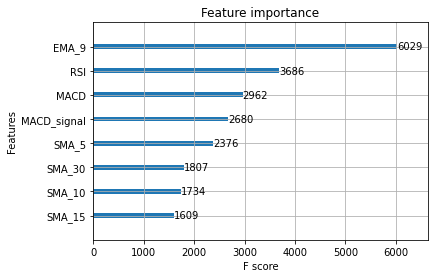

In [46]:
plot_importance(model);

In [47]:
y_pred = model.predict(X_test)
print(f'y_true = {np.array(y_test)[:5]}')
print(f'y_pred = {y_pred[:5]}')

y_true = [31376.22220807 31370.61391035 31455.56002017 31499.37481417
 31603.43139624]
y_pred = [32636.902 32241.502 31364.672 31262.375 31297.498]


In [48]:
print(f'mean_squared_error = {mean_squared_error(y_test, y_pred)}')

mean_squared_error = 882155.0970962453


In [53]:
predicted_prices = prices_data.loc[test_split_idx+1:].copy()
predicted_prices['prices'] = y_pred

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=prices_data.time, y=prices_data.prices,
                         name='Truth',
                         marker_color='LightSkyBlue'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.time,
                         y=predicted_prices.prices,
                         name='Prediction',
                         marker_color='MediumPurple'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.time,
                         y=y_test,
                         name='Truth',
                         marker_color='LightSkyBlue',
                         showlegend=False), row=2, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.time,
                         y=y_pred,
                         name='Prediction',
                         marker_color='MediumPurple',
                         showlegend=False), row=2, col=1)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'marker': {'color': 'LightSkyBlue'},
              'name': 'Truth',
              'type': 'scatter',
              'x': [2021-05-15 12:01:58, 2021-05-15 13:11:29, 2021-05-15 14:02:14,
                    ..., 2021-07-27 23:01:16, 2021-07-28 00:00:59, 2021-07-28
                    01:00:31],
              'xaxis': 'x',
              'y': array([49379.76315234, 49052.68444472, 49675.90532371, ..., 39076.59377063,
                          39123.75375106, 39850.2021842 ]),
              'yaxis': 'y'},
             {'marker': {'color': 'MediumPurple'},
              'name': 'Prediction',
              'type': 'scatter',
              'x': [2021-07-17 02:01:31, 2021-07-17 03:00:03, 2021-07-17 04:00:03,
                    ..., 2021-07-27 23:01:16, 2021-07-28 00:00:59, 2021-07-28
                    01:00:31],
              'xaxis': 'x',
              'y': array([32636.902, 32241.502, 31364.672, ..., 38784.438, 39022.51 , 39298.36 ],
                         dtype=float32),
              'yaxis': 'y'},
             {'marker': {'color': 'LightSkyBlue'},
              'name': 'Truth',
              'showlegend': False,
              'type': 'scatter',
              'x': [2021-07-17 02:01:31, 2021-07-17 03:00:03, 2021-07-17 04:00:03,
                    ..., 2021-07-27 23:01:16, 2021-07-28 00:00:59, 2021-07-28
                    01:00:31],
              'xaxis': 'x2',
              'y': array([31376.22220807, 31370.61391035, 31455.56002017, ..., 39076.59377063,
                          39123.75375106, 39850.2021842 ]),
              'yaxis': 'y2'},
             {'marker': {'color': 'MediumPurple'},
              'name': 'Prediction',
              'showlegend': False,
              'type': 'scatter',
              'x': [2021-07-17 02:01:31, 2021-07-17 03:00:03, 2021-07-17 04:00:03,
                    ..., 2021-07-27 23:01:16, 2021-07-28 00:00:59, 2021-07-28
                    01:00:31],
              'xaxis': 'x2',
              'y': array([32636.902, 32241.502, 31364.672, ..., 38784.438, 39022.51 , 39298.36 ],
                         dtype=float32),
              'yaxis': 'y2'}],
    'layout': {'template': '...',
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0]},
               'xaxis2': {'anchor': 'y2', 'domain': [0.0, 1.0]},
               'yaxis': {'anchor': 'x', 'domain': [0.575, 1.0]},
               'yaxis2': {'anchor': 'x2', 'domain': [0.0, 0.425]}}
})